In [ ]:
# DeCET application to REMC adult tissues

In [1]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '5_11_20' # Change this to today's date for output names.

input_dir = '../DeCET_REMC/' # directory where the HOSVD files can be found
file_prefix = 'DeCET_REMC_adult_tissues_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_pt = 34
n_as = 5
fp.close()

sample_proj = np.zeros((n_pt, n_as, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1]] = projections[k]
assay_name = ['H3K27ac', 'H3K27me3', 
              'H3K9me3', 'H3K4me3', 'H3K4me1']

170 170


In [3]:
def matrix_cosine(X, Y):
    """Calculates the matrix cosine distance.
    
    The cosine distance is computed for matching
    rows of the X and Y matrices and these values
    are summed over the rows.
    """
    K, N = X.shape
    dist = 0.0
    for k in range(K):
        dist += scipy.spatial.distance.cosine(X[k,:], Y[k,:])
    return dist

# Calculate the adjusted matrix cosine distance between 
# each pair of tissue samples.
# Select the number of location vectors to use for clustering.
use = [i for i in range(13)]
tissue_sample = np.copy(sample_proj[:,:,use])
print(tissue_sample.shape)

# Mean center the data across tissue samples for each assay.
for k in range(n_as):
    tissue_sample[:,k,:] = tissue_sample[:,k,:] - np.mean(tissue_sample[:,k,:], axis=0)
    
print(tissue_sample.shape)
D = np.zeros((n_pt, n_pt))
for i in range(n_pt):
    for j in range(n_pt):
        D[i,j] = matrix_cosine(tissue_sample[i], tissue_sample[j])

(34, 5, 13)
(34, 5, 13)


In [4]:
# Colors and cell/tissue type labels for the REMC data
distinct_colors = [(180/255, 180/255, 180/255, 1),
                   (255/255, 225/255, 25/255, 1), (0/255, 130/255, 200/255, 1),
                   (245/255, 130/255, 48/255, 1), (145/255, 30/255, 180/255, 1),
                   (70/255, 240/255, 240/255, 1), (240/255, 50/255, 230/255, 1),
                   (210/255, 245/255, 60/255, 1), (250/255, 190/255, 190/255, 1),
                   (0/255, 128/255, 128/255, 1), (230/255, 190/255, 255/255, 1)]

anatomy_colors = [distinct_colors[0], distinct_colors[0], distinct_colors[0],
                  distinct_colors[0], distinct_colors[0], distinct_colors[0],
                  distinct_colors[1], distinct_colors[1], distinct_colors[1],
                  distinct_colors[2], distinct_colors[2], distinct_colors[2],
                  distinct_colors[2], distinct_colors[2],
                  distinct_colors[1], distinct_colors[1],
                  distinct_colors[3], distinct_colors[3], distinct_colors[3],
                  distinct_colors[3], distinct_colors[3],
                  distinct_colors[4], distinct_colors[4],
                  distinct_colors[5], distinct_colors[6],
                  distinct_colors[6], distinct_colors[6], distinct_colors[6],
                  distinct_colors[7], distinct_colors[8], distinct_colors[8],
                  distinct_colors[7], distinct_colors[7], distinct_colors[7]] 
    
anatomy_classes = ["Digestive", "Epithelial", "Brain", "Blood & T cell",
                   "HSC & B cell", "Adipose", "Smooth muscle", "Heart",
                   "Muscle"]

In [5]:
# Reorder the assays to group marks associated with active and repressive
# gene transcription. This makes it easier to see trends in the projections.
reorder_assays = [0,3,4,1,2]

# Colors for the assay and location vectors.
assay_colors = [(51/255,70/255,0,1.0), (204/255,20/255,204/255,1.0), 
                (104/255,20/255,104/255,1.0), (204/255,102/255,0,1.0), (162/255,148/255,80/255,1.0)]
index_order = []
col_loc_color = []
single_col_color = []
col_assay = []
for l in range(len(use)):
    if(l % 2 == 0):
        single_col_color.append('k')
    else:
        single_col_color.append((0.5,0.5,0.5,1))
    for k in range(n_as):
        index_order.append(len(use)*k + l)
        col_assay.append(assay_colors[reorder_assays[k]])
    if(l % 2 == 0):
        for k in range(n_as):
            col_loc_color.append('k')
    else:
        for k in range(n_as):
            col_loc_color.append((0.5,0.5,0.5,1))

In [6]:
# Full and reduced labels for the REMC data files used in this study.
sample_labels = ['E109 Small intestine', 'E079 Esophagus', 'E075 Colonic mucosa',
                 'E106 Sigmoid colon', 'E094 Gastric', 'E101 Rectal mucosa',
                 'E058 Foreskin keratinocyte primary cells', 'E059 Foreskin melanocyte primary cells',
                 'E061 Foreskin melanocyte primary cells',
                 'E071 Brain hippocampus middle', 'E072 Brain inferior temporal lobe',
                 'E073 Brain dorsolateral prefrontal cortex',
                 'E067 Brain angular gyrus', 'E069 Brain cingulate gyrus',
                 'E055 Foreskin fibroblast primary cells', 'E056 Foreskin fibroblast primary cells',
                 'E039 Primary T helper naive cells from peripheral blood',
                 'E038 Primary T helper naive cells from peripheral blood',
                 'E062 Primary mononuclear cells from peripheral blood',
                 'E047 Primary T CD8+ naive cells from peripheral blood',
                 'E048 Primary T CD8+ memory cells from peripheral blood',
                 'E032 Primary B cells from peripheral blood',
                 'E046 Primary NK cells peripheral blood',
                 'E063 Adipose nuclei', 'E076 Colon smooth muscle',
                 'E078 Duodenum smooth muscle', 'E103 Rectal smooth muscle',
                 'E111 Stomach smooth muscle', 'E065 Aorta', 'E100 Psoas muscle',
                 'E108 Skeletal muscle female', 'E095 Left ventricle',
                 'E104 Right atrium', 'E105 Right ventricle']


sample_labels_short = ['E109', 'E079', 'E075', 'E106', 'E094', 'E101',
                       'E058', 'E059', 'E061', 'E071', 'E072', 'E073',
                       'E067', 'E069', 'E055', 'E056', 'E039', 'E038',
                       'E062', 'E047', 'E048', 'E032', 'E046', 'E063',
                       'E076', 'E078', 'E103', 'E111', 'E065', 'E100',
                       'E108', 'E095', 'E104', 'E105']

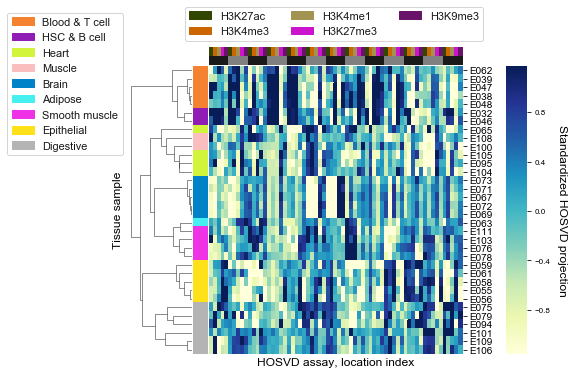

In [7]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.legend import Legend
# Figure 2A (unsupervised hierarchical clustering of tissue samples)
legend_order = [3, 4, 7, 8, 2, 5, 6, 1, 0]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip([distinct_colors[i] for i in legend_order], [anatomy_classes[i] for i in legend_order])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0),
                             np.std(full_sample_proj, axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=anatomy_colors,
                       col_colors=[col_assay, col_loc_color],
                       xticklabels=[], yticklabels=sample_labels_short, figsize=(6,7),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.82,0.67), handles=legend_an,
                       frameon=True, fontsize=11)

g.cax.legend(loc='lower left', bbox_to_anchor=(-15.1,1.07), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=3)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)
g.savefig(output_dir + 'figures/figure2_panels/' + file_prefix + '_panelA_clustering_' +
          date + '.pdf', format='pdf', transparent=True)

In [8]:
np.sort(use) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

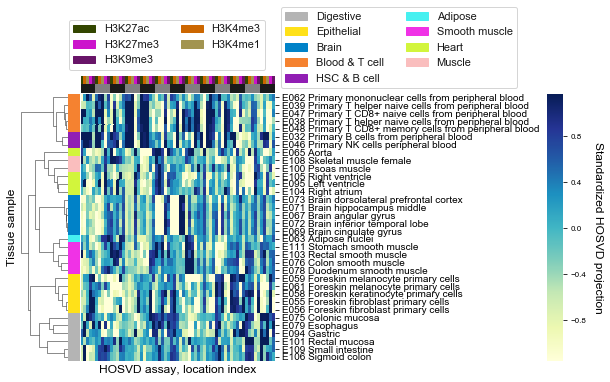

In [9]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.legend import Legend
# Figure 1C (unsupervised hierarchical clustering of tissue samples)
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip(['r', 'g', 'b'], ["Endo", "Ecto", "Meso"])]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip(distinct_colors, anatomy_classes)]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip(assay_colors, assay_name)]
#legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip(col_assay_color[:3], col_labels[:3])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0), np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=anatomy_colors,
                       col_colors=[col_assay, col_loc_color],
                       xticklabels = [], yticklabels=sample_labels, figsize=(4.6,6.5),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10)
g.ax_col_dendrogram.set_visible(False)
#g.cax.set_position([0.91,0.125,0.05,0.57])
g.cax.set_position([1.72,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
# l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.66,1.00), handles=legend_an,
#                        frameon=True, fontsize=11)
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(1.0,1.00), handles=legend_an,
                       frameon=True, fontsize=11, ncol=2)

g.cax.legend(loc='lower left', bbox_to_anchor=(-29.2,1.07), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=2)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

In [10]:
# Load in the decomposition of the genomic location space.
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_2.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]
print(U_l.shape)

(1440549, 170)


In [11]:
# The genomic bins used for the hg19 genome. chrY is 
# removed from the data before the HOSVD. Since chrY is
# at the end of the chromosome list used, this is
# not a problem.
chr_list = abf.getChrList()
chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [12]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# the conditions.

# Select the location vector of interest (zero indexed).
loc_vec = 11

# Set the threshold for a vector component to be considered significant.
# The empirical distribution of component values from all vectors is used
# to set the threshold.

cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')

significant_pos = []
significant_neg = []
for i in range(L_genome):
    if(U_l[i,loc_vec] > cut):
        significant_pos.append(i)
    elif(U_l[i,loc_vec] < -cut):
        significant_neg.append(i)
        
print(len(significant_pos), 'positive')
print(len(significant_neg), 'negative')

# Save the regions exhibiting epigenetic alterations 
# between leiomyoma and myometrium. 1-based indexing
# is used for the file names.

output_pos = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(loc_vec+1) + '_final.txt','w+')

for l in range(0,len(significant_pos)):
            output_pos.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0], genomic_bin[significant_pos[l]][1], genomic_bin[significant_pos[l]][2]))     
output_pos.close()

output_neg = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(loc_vec+1) + '_final.txt','w+')

for l in range(0,len(significant_neg)):
            output_neg.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0], genomic_bin[significant_neg[l]][1], genomic_bin[significant_neg[l]][2]))
output_neg.close()

1374 positive
1965 negative
